In [1]:
import os.path as op

from surfplot.utils import add_fslr_medial_wall
from neuromaps.datasets import fetch_fslr
from sklearn.cluster import KMeans
from surfplot import Plot
from sklearn.metrics import pairwise_distances
from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib
import numpy as np

In [2]:
SPACE, DENSITY = "fsLR", "32k"
DSET, MODEL = "neuroquery", "lda"

data_dir = op.join(".", "temp_fig")
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")

In [3]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

In [4]:
gradients = np.load("../results/gradient/gradients.npy")

template_dir = "../data/templates"
subcortical_fn = op.join(template_dir, "rois-subcortical_mni152_mask.nii.gz")
subcort_img = nib.load(subcortical_fn)

full_vertices = 64984
hemi_vertices = full_vertices // 2

subcort_dat = subcort_img.get_fdata()
subcort_mask = subcort_dat != 0
n_subcort_vox = np.where(subcort_mask)[0].shape[0]

n_gradients = gradients.shape[1]
grad_lst = []
for i in range(n_gradients):
    cort_grads = gradients[: gradients.shape[0] - n_subcort_vox, i]
    grad_lst.append(cort_grads)

grad_arr = np.array(grad_lst).T

In [5]:
seg_dir = "../results/segmentation/KMeans_gradient-maps"
n_clusters = 2
n_dim = 1
sigma_0 = 0.1

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

full_vertices = 64984
hemi_vertices = full_vertices // 2

cmap = "YlOrRd"
act_maps = []
for region in range(n_clusters):
    map_lh = op.join(seg_dir, f"source-KMeans{n_clusters:02d}_desc-C{region:02d}_space-fsLR_den-32k_hemi-L_feature.func.gii")
    map_rh = op.join(seg_dir, f"source-KMeans{n_clusters:02d}_desc-C{region:02d}_space-fsLR_den-32k_hemi-R_feature.func.gii")
    map_arr_lh = nib.load(map_lh).agg_data()
    map_arr_rh = nib.load(map_rh).agg_data()
    pseudo_act_map = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map
    corrs_df = decode.transform([pseudo_act_map], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )
    filtered_df.columns = ["r"]

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    # Radar plot
    plot_radar(
        corrs, 
        filtered_features,
        MODEL,
        cmap=cmap,
        out_fig=op.join(data_dir, f"od_{region:02d}_radar.png"),
    )

    # Word cloud plot
    plot_cloud(
        corrs, 
        filtered_features,
        filtered_frequencies,
        MODEL, 
        cmap=cmap,
        data_dir=data_dir,
        out_fig=op.join(data_dir, f"od_{region:02d}_wordcloud.png"),
    )


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
/Users/jperaza/Documents/GitHub/gradec/gradec/plot.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)[sorted_indices]
100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
/Users/jperaza/Documents/GitHub/gradec/gradec/plot.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)[sorted_indices]


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
/Users/jperaza/Documents/GitHub/gradec/gradec/plot.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)[sorted_indices]
/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_37210/1371862202.py:100: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
/Users/jperaza/Documents/GitHub/gradec/gradec/plot.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' w

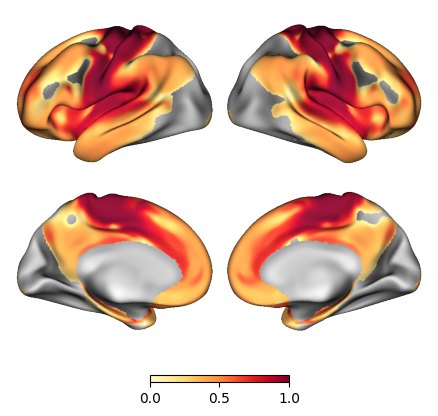

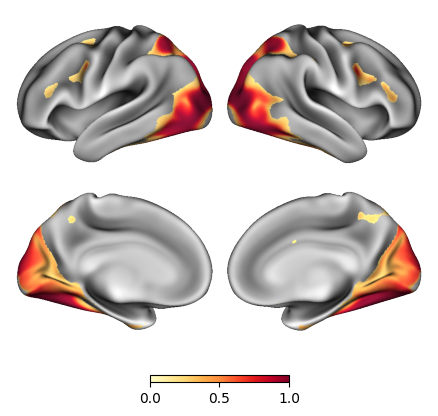

In [18]:
dim = 2
cmap = "YlOrRd"
grad_ = grad_arr[:, dim]
n_segment = 2
kmeans_model = KMeans(
    n_clusters=n_segment,
    init="k-means++",
    n_init=10,
    random_state=0,
    algorithm="elkan",
).fit(grad_.reshape(-1, 1))
# Get order mapper from map_peaks
peaks = kmeans_model.cluster_centers_
map_peaks = peaks[:, 0].flatten()  # Order base on principal gradient
order_idx = np.argsort(map_peaks)
order_mapper = np.zeros_like(order_idx)
order_mapper[order_idx] = np.arange(n_segment)

max_peak, min_peak = grad_.max(), grad_.min()
peaks[0], peaks[-1] = min_peak, max_peak

# Reorder labels based on map_peaks order
labels = order_mapper[kmeans_model.labels_]

n_clusters = 2
n_dim = 1
sigma_0 = 1

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

full_vertices = 64984
hemi_vertices = full_vertices // 2

act_maps = []
for region in range(n_clusters):
    # zero-out all regions except 71 and 72
    indices = np.where(labels==region)[0]
    grad_val = grad_[indices]
    peak_coords = peaks[region]
    distances = pairwise_distances(
        grad_val.reshape(-1, 1), 
        peak_coords.reshape(1, -1), 
        metric="euclidean"
    ).flatten()
    mean_dist = np.mean(distances)
    sigma = mean_dist * sigma_0
    affinity =  np.exp(-distances**2 / (2 * sigma**2))

    pseudo_act_map = np.zeros_like(labels, dtype=float)
    
    pseudo_act_map[indices] = np.array(affinity)
    act_maps.append(pseudo_act_map)

    prin_grad = add_fslr_medial_wall(pseudo_act_map)  # Add medial wall for plotting
    data_lh, data_rh = prin_grad[:hemi_vertices], prin_grad[hemi_vertices:full_vertices]

    # Decode map
    corrs_df = decode.transform([pseudo_act_map], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )
    filtered_df.columns = ["r"]

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    # Radar plot
    plot_radar(
        corrs, 
        filtered_features,
        MODEL,
        cmap=cmap,
        out_fig=op.join(data_dir, f"{dim}-{region:02d}_radar.png"),
    )

    # Word cloud plot
    plot_cloud(
        corrs, 
        filtered_features,
        filtered_frequencies,
        MODEL, 
        cmap=cmap,
        data_dir=data_dir,
        out_fig=op.join(data_dir, f"{dim}-{region:02d}_wordcloud.png"),
    )


    p = Plot(lh, rh)
    p.add_layer({'left': sulc_lh, 'right': sulc_rh}, cmap='binary_r', cbar=False)
    p.add_layer({'left': data_lh, 'right': data_rh}, color_range=(0, 1), cmap="YlOrRd")
    fig = p.build()
    fig.savefig(op.join(data_dir, f"{dim}-{region:02d}_map.tiff"), bbox_inches="tight", dpi=500)
    fig.show()